In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
path_products = os.path.abspath("../datasets/predict_categories_dataset_products.jsonl.gz")
path_dataset = os.path.abspath("dataset/dataset.pkl")


In [3]:
"""approx time 40sec"""
from IPython.display import clear_output
import gzip
import json
# make df from json
rows = []
with gzip.open(path_products) as f:
    for i, line in enumerate(f):
        json_line = json.loads(line)
        code = json_line['code']
        categories_tags = json_line['categories_tags']
        rows.append([code, categories_tags])

df_categories = pd.DataFrame(rows, columns = ["code", "categories_tags"]).set_index("code", drop = True)

In [4]:
df = pd.read_pickle(path_dataset)
df = df.drop_duplicates(subset = "code")
empty_or_noise = df["word_selection"].str.len() < 10
print("noise or empty lines:", empty_or_noise.sum())
df = df[~empty_or_noise]
dataset = df[["code", "word_selection", "keys"]]
dataset = dataset.merge(df_categories, left_on="code", right_on="code")
print(dataset.shape)
del df
del df_categories


noise or empty lines: 194
(596366, 4)


In [5]:
dataset.head()

,code,word_selection,keys,categories_tags
0,0021065000071,Facts Calories Nutrition servings container Se...,[1],"[en:groceries, en:sauces]"
1,0021065000101,Steves Eds ORIGINAL Louisiana Hot Sauce. . . ...,"[2, 1]","[en:groceries, en:sauces, en:hot-sauces]"
2,0021078019091,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,[1],"[en:dietary-supplements, en:bodybuilding-suppl..."
3,0021110336001,Whole Sighature MAD White Potatoes SEA kitchen...,[1],"[en:plant-based-foods-and-beverages, en:plant-..."
4,0021130008124,DISTRIBUTED BY Nutrition Facts SAFEWAY INC PO ...,"[2, 1]","[en:groceries, en:sauces, en:tomato-sauces, en..."


In [6]:
## keep only normalized categories
from tqdm import tqdm
import urllib.request, json 
with urllib.request.urlopen("https://static.openfoodfacts.org/data/taxonomies/categories.json") as url:
    normalized_categories_dict = json.loads(url.read().decode())

def get_normalizerd_categories_and_frequent_ones(category_list, normalized_categories_dict, categories_with_more_than_n_occurences):
  category_selection = []
  for list_ in tqdm(category_list):
    categories_normalized = [
                             category for category in list_ if (
                                 category in normalized_categories_dict 
                                 and category in categories_with_more_than_n_occurences
                                 )]
    category_selection.append(categories_normalized)
  return category_selection

def get_freq_dict(category_list):
  cat_dict = {}
  for list_ in category_list:
    if isinstance(list_, str):
      list_ = eval(list_)
    for category in list_:
      if category in cat_dict:
        cat_dict[category] += 1
      else:
        cat_dict[category] = 1
  return cat_dict

def get_categories_with_more_than_n_occurencs(category_list, freq_dict, n_freq = 49):
  categories_with_more_than_n_occurences = [cat for (cat, freq) in freq_dict.items() if freq > n_freq]
  return categories_with_more_than_n_occurences

freq_dict = get_freq_dict(dataset["categories_tags"])
frequent_categories = get_categories_with_more_than_n_occurencs(dataset["categories_tags"], freq_dict, n_freq = 49)
category_normalized = get_normalizerd_categories_and_frequent_ones(dataset["categories_tags"], normalized_categories_dict, frequent_categories)
dataset["category_normalized"] = category_normalized
filter = dataset["category_normalized"].str.len() != 0
dataset = dataset.loc[filter, :].copy()

100%|██████████| 596366/596366 [00:08<00:00, 71714.48it/s] 


In [7]:
categories_freq = {}
for categories_list in dataset["category_normalized"]:
    for category in categories_list:
        if category in categories_freq:
            categories_freq[category]+=1
        else:
            categories_freq[category]=1

def sort_dict(dict_):
    return {k:v for k,v in sorted(dict_.items(), key = lambda x: x[1], reverse = True)}
#sort_dict(categories_freq)

def fill_cat(categories_list, cat_to_match, list_):
    if cat_to_match in categories_list:
        list_.append([1])
    else:
        list_.append([0])
    return list_

#'en:sweet-snacks'
#'en:meats'
#'en:brown-rices'

sweet_snacks = []
meats_ = []
brown_rices = []
for categories_list in dataset["category_normalized"]:
    sweet_snacks = fill_cat(categories_list, 'en:sweet-snacks', sweet_snacks)
    meats_ = fill_cat(categories_list, 'en:meats', meats_)
    brown_rices = fill_cat(categories_list, 'en:brown-rices', brown_rices)

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [21]:
from tqdm import tqdm
embeddings_list = []
append = embeddings_list.append
for text in tqdm(dataset["word_selection"]):
    append(model.encode(text))

100%|██████████| 596366/596366 [3:39:07<00:00, 45.36it/s]  


In [22]:
"""
import pickle
with open('embeddings.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(embeddings_list, file)
"""

In [157]:
import pickle
with open('embeddings.pkl', 'rb') as file:
    # A new file will be created
    embeddings_list = pickle.load(file)

In [ ]:
### Make labels
#from sklearn.preprocessing import MultiLabelBinarizer
#mlb = MultiLabelBinarizer()
#y_multilabels = mlb.fit_transform([eval(item) for item in dataset["categories_tags"]])

In [190]:
np.sum(meats_)

52925

In [102]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [122]:
#embeddings_list = np.array(embeddings_list)[filter].shape
sample_idx = np.random.choice(range(len(embeddings_list)), 200000)

In [148]:
y = np.array(meats_).ravel()
def get_sample(y):
    total_ones = y.sum()
    y_1_indexes = np.where(y==1)[0]
    y_0_indexes = np.where(y==0)[0]
    y_0_indexes_sample = np.random.choice(y_0_indexes, total_ones, replace = False)
    return list(y_1_indexes) + list(y_0_indexes_sample)

In [160]:
embeddings_list = np.array(embeddings_list)[filter]

In [150]:
indexes = get_sample(y)

52925

In [168]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
X = np.array(embeddings_list)[indexes]
y = np.array(meats_).ravel()[indexes]
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train,y_train)

#y_pred = knn.predict(X)
y_pred = clf.predict(X_train)

print(classification_report(y_train, y_pred))




              precision    recall  f1-score   support

           0       0.85      0.84      0.84     42663
           1       0.84      0.84      0.84     42017

    accuracy                           0.84     84680
   macro avg       0.84      0.84      0.84     84680
weighted avg       0.84      0.84      0.84     84680



<AxesSubplot:>

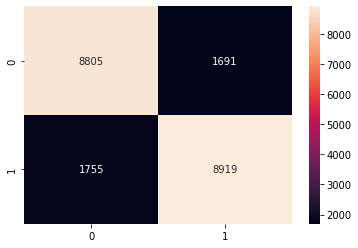

In [167]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = ".0f")

In [135]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [405]:
dataset["word_selection"]

,code,word_selection,categories_tags,category_normalized
0,0021065000071,Facts Calories Nutrition servings container Se...,"[en:groceries, en:sauces]",[en:sauces]
1,0021065000101,Steves Eds ORIGINAL Louisiana Hot Sauce. . . ...,"[en:groceries, en:sauces, en:hot-sauces]","[en:sauces, en:hot-sauces]"
2,0021078019091,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,"[en:dietary-supplements, en:bodybuilding-suppl...","[en:dietary-supplements, en:bodybuilding-suppl..."
3,0021110336001,Whole Sighature MAD White Potatoes SEA kitchen...,"[en:plant-based-foods-and-beverages, en:plant-...","[en:plant-based-foods-and-beverages, en:plant-..."
4,0021130008124,DISTRIBUTED BY Nutrition Facts SAFEWAY INC PO ...,"[en:groceries, en:sauces, en:tomato-sauces, en...","[en:sauces, en:tomato-sauces, en:ketchup]"
...,...,...,...,...
596361,3700701300290,. sel. . VALEURS NUTRITIONNELLES MOYENNES en p...,"[en:snacks, en:sweet-snacks, en:biscuits-and-c...","[en:snacks, en:sweet-snacks, en:biscuits-and-c..."
596362,7802220650002,. . . ENVAE BOGAR LIAPYAR INGREDIENTES Trigo D...,"[en:plant-based-foods-and-beverages, en:plant-...","[en:plant-based-foods-and-beverages, en:plant-..."
596363,0781718996204,. . jose. Ingredientes Miel Abeja Duración Ind...,"[en:breakfasts, en:spreads, en:sweet-spreads, ...","[en:breakfasts, en:spreads, en:sweet-spreads, ..."
596364,3258565412401,. . . Ao NE JAMAIS seo best before Par portion...,"[en:plant-based-foods-and-beverages, en:plant-...","[en:plant-based-foods-and-beverages, en:plant-..."


### Bert

In [11]:
dataset["word_selection"].shape

(572141,)

In [12]:
y = np.array(meats_)
y[:5], y.shape


(array([[0],
        [0],
        [0],
        [0],
        [0]]),
 (572141, 1))

In [19]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_visible_devices(physical_devices[1:], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    assert len(logical_devices) == len(physical_devices) - 1
except:
   pass

In [13]:
from sklearn.model_selection import train_test_split
batch_size = 64
### Make df
X = dataset["word_selection"]
y = np.array(meats_).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(64)
#test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(len(X_test)).batch(64)
max_length = dataset["word_selection"].str.split().str.len().max()
max_length

240

In [40]:
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel, BertConfig, BertTokenizerFast

In [41]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.9.1
Eager mode:  True
GPU is available


In [43]:
model_name = "bert-base-multilingual-uncased"
config = BertConfig.from_pretrained(model_name, num_labels=2)
tokenizer = BertTokenizerFast.from_pretrained(model_name, config=config)
config.output_hidden_states = False

In [96]:
transformer_model

In [98]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# Load the MainLayer
bert = transformer_model.layers[0]
# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
#inputs = {'input_ids': input_ids}
# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(input_ids)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)
# Then build your model output
issue = Dense(units=1, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='issue')(pooled_output)
outputs = issue
#product = Dense(units=len(data.Product_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='product')(pooled_output)
# And combine it all in a model object
model = Model(inputs=input_ids, outputs=outputs, name='BERT_MultiLabel_MultiClass')
# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 240)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  177853440 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             240, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                        

In [39]:
def bert_model():
    config = BertConfig.from_pretrained(model_name, num_labels=2)
    bert_model = TFBertModel.from_pretrained(model_name, config=config)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    #last_hidden_states = bert_model(input_word_ids, training=False)[0]    
    embedding = bert_model(input_word_ids, training=False)[1]
    #x = tf.keras.layers.LSTM(100, dropout=0.3, recurrent_dropout=0.3)(last_hidden_states)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(embedding)
    #output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=output)
    
    return model

In [27]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [19]:
"""takes 10 min"""
train_encoded = bert_encode(X_train)
dev_encoded = bert_encode(X_test)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(len(X_train))
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, y_test))
    .shuffle(len(X_test))
    .batch(batch_size)
)

In [62]:
def tokenizer_custom(X):
    x = tokenizer(
        text=X.to_list(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = False,
        verbose = True)
    return x

In [87]:
train = tokenizer_custom(X_train)
test = tokenizer_custom(X_test)


In [93]:
train = tf.data.Dataset.from_tensor_slices((train['input_ids'], y_train)).shuffle(len(X_train)).batch(batch_size)
test = tf.data.Dataset.from_tensor_slices((test['input_ids'], y_test)).shuffle(len(X_test)).batch(batch_size)

In [99]:
    #######################################
### ------- Train the model ------- ###
# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

metrics = [
      #macro_f1,
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      #tfa.metrics.F1Score(num_classes= N_LABELS, average= 'macro', threshold=0.5),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metrics)
# Ready output data for the model

# Fit the model
history = model.fit(
    x=train,
    validation_data = test,
    epochs=3)

Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-99-c540a85705c0>", line 29, in <cell line: 29>
      history = model.fit(
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/training.py", line 894, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/metrics/metrics.py", line 818, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.debugging.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-99-c540a85705c0>", line 29, in <cell line: 29>
      history = model.fit(
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/training.py", line 894, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/metrics/metrics.py", line 818, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/Users/az/miniforge3/envs/tf-py39/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.debugging.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (BERT_MultiLabel_MultiClass/issue/BiasAdd:0) = ] [[0.0762611181][-0.0630490184][-0.000275934115]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_greater_equal_1/Assert/AssertGuard/branch_executed/_29/_609]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (BERT_MultiLabel_MultiClass/issue/BiasAdd:0) = ] [[0.0762611181][-0.0630490184][-0.000275934115]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_227666]

In [47]:
metrics = [
      #macro_f1,
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      #tfa.metrics.F1Score(num_classes= N_LABELS, average= 'macro', threshold=0.5),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

#model = bert_model()
loss = tf.keras.losses.BinaryCrossentropy()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss=loss,optimizer=adam_optimizer,metrics=metrics)

In [51]:
y_issue = to_categorical(meats_)

In [74]:
batch_size = 64

In [83]:
"""
history = model.fit(
    train_dataset,
    epochs=1,
    validation_data=dev_dataset)
"""
history = model.fit(
    x=train,
    validation_data = test,
    batch_size=batch_size,
    epochs=3)

ValueError: `y` argument is not supported when using dataset as input.

In [81]:
#from tensorflow.keras.layers import Input, Dropout, Dense
#from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.initializers import TruncatedNormal
#from tensorflow.keras.losses import CategoricalCrossentropy
#from tensorflow.keras.metrics import CategoricalAccuracy
#from tensorflow.keras.utils import to_categorical

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
#from official.nlp import optimization  # to create AdamW optimizer

#import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')


In [82]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.9.1
Eager mode:  True
GPU is available


In [83]:
from sklearn.model_selection import train_test_split

### Make df
X = dataset["word_selection"]
y = np.array(meats_).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(64)
test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(len(X_test)).batch(64)
max_length = dataset["word_selection"].str.split().str.len().max()
max_length

240

In [19]:
max_length = dataset["word_selection"].str.split().str.len().max()
max_length

240

In [84]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3"
#https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
#Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3

In [85]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [103]:
def build_classifier_model():
  #text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  #preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  #encoder_inputs = preprocessing_layer(text_input)
  input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(input_word_ids)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(input_word_ids, net)
  #return tf.keras.Model(text_input, net)

In [105]:
model = bert_model()#build_classifier_model()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [88]:
with tf.device('/cpu:0'):
    text_test = ["mother of dragons"]
    bert_raw_result = model(tf.constant(text_test))
    print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.34575933]], shape=(1, 1), dtype=float32)


In [89]:
#with tf.device("/GPU:0")
with tf.device('/cpu:0'):
    text_test = ['this is such an amazing movie!']
    text_preprocessed = bert_preprocess_model(text_test)

    print(f'Keys       : {list(text_preprocessed.keys())}')
    print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
    print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
    print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
    print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101 10531 10124 11049 10151 28149 19308 18379   106   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [37]:
#tf.keras.utils.plot_model(model)

In [109]:
metrics = [
      #macro_f1,
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      #tfa.metrics.F1Score(num_classes= N_LABELS, average= 'macro', threshold=0.5),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
"""
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
"""
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [110]:
print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train_encoded,
                            validation_data=dev_encoded,
                            epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<AxesSubplot:>

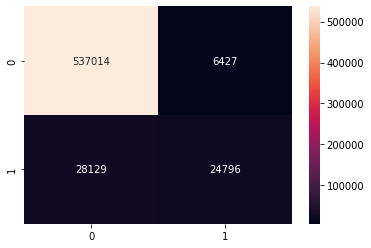

In [117]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot = True, fmt = ".0f")

# spot categories

In [8]:
from utils.word_selection import show_images_from_barcode
from utils.preprocessing import parallel_calc, parallel_calc_multi
import multiprocess as mp
from scipy.sparse import csr_matrix
shared_d = mp.Manager().dict()

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(sparse_output = True)

y_labels_matrix =  mlb.fit_transform(dataset["category_normalized"])

In [102]:
from tqdm import tqdm

In [209]:
dataset.head(3)

,code,word_selection,keys,categories_tags,category_normalized
0,0021065000071,Facts Calories Nutrition servings container Se...,[1],"[en:groceries, en:sauces]",[en:sauces]
1,0021065000101,Steves Eds ORIGINAL Louisiana Hot Sauce. . . ...,"[2, 1]","[en:groceries, en:sauces, en:hot-sauces]","[en:sauces, en:hot-sauces]"
2,0021078019091,SOURCE NATURALS DIETARY SUPPLEMENT TRUE WHEY T...,[1],"[en:dietary-supplements, en:bodybuilding-suppl...","[en:dietary-supplements, en:bodybuilding-suppl..."


In [391]:
cat_sorted = dataset.reset_index()["category_normalized"].str.len().sort_values()

In [10]:
import multiprocess as mp
shared_d = mp.Manager().dict()

In [19]:
history = {}
dicto = {}
shared_d = mp.Manager().dict()
barcode_list = dataset["code"].values

In [12]:

def get_intersect_rows(cols):
    ones = np.ones_like(cols).reshape(-1,1)
    rows, _ = (y_labels_matrix[:,cols].sum(axis=1) == cols.shape[0]).nonzero()
    return rows
    
def find_new_categories_with_probs(i):
    threshold = 0.5
    _, cols = y_labels_matrix[i].nonzero()
    row_indexes_intersect = get_intersect_rows(cols)
    N_intersect = row_indexes_intersect.shape[0]

    ratios = (y_labels_matrix[row_indexes_intersect].sum(axis = 0)/N_intersect)
    col_idx_greater_than_thresh = np.where(ratios > threshold)[1]
    categories_idx_to_add = list(set.difference(*sorted([set(cols), set(col_idx_greater_than_thresh)], reverse = True)))

    categories_to_add = list(mlb.classes_[categories_idx_to_add])
    ratios_to_add = np.array(ratios)[0,categories_idx_to_add]
    
    return list(categories_to_add), list(ratios_to_add), N_intersect

#for parrallel computation
def find_new_categories_with_probs_2(i):
    threshold = 0.5
    barcode = barcode_list[i]
    _, cols = y_labels_matrix[i].nonzero()
    row_indexes_intersect = get_intersect_rows(cols)
    N_intersect = row_indexes_intersect.shape[0]

    ratios = (y_labels_matrix[row_indexes_intersect].sum(axis = 0)/N_intersect)
    col_idx_greater_than_thresh = np.where(ratios > threshold)[1]
    categories_idx_to_add = list(set.difference(*sorted([set(cols), set(col_idx_greater_than_thresh)], reverse = True)))

    categories_to_add = mlb.classes_[categories_idx_to_add]
    ratios_to_add = np.array(ratios)[0,categories_idx_to_add]
    
    if len(categories_to_add) > 0:
        shared_d[barcode] = {
            "categories_to_add": list(categories_to_add),
            "probs": list(ratios_to_add),
            "N_intersections": N_intersect
        }


In [20]:
#
from tqdm import tqdm
#threshold = 0.5
for i, barcode in enumerate(tqdm(dataset["code"].iloc[:2000])):
    if barcode not in history:
        history[barcode] = 0
        categories_to_add, ratios_to_add, N_intersect = find_new_categories_with_probs(i)
        if len(categories_to_add) > 0:
            dicto[barcode] = {
                "categories_to_add": categories_to_add,
                "probs": ratios_to_add,
                "N_intersections": N_intersect
                }


100%|██████████| 2000/2000 [00:31<00:00, 63.07it/s]


In [21]:
"""takes approx 33min"""
import json

r = parallel_calc(find_new_categories_with_probs_2, range(barcode_list[:2000].shape[0]))
print(len(shared_d))

"""
with open("missing_categories.json", "w") as f:
    json.dump(dict(shared_d), f)
"""

454


'\nwith open("missing_categories.json", "w") as f:\n    json.dump(dict(shared_d), f)\n'

In [50]:
with open("missing_categories.json") as f:
    missing_categories = json.load(f)

In [51]:
missing_categories_sorted = {k:v for (k,v) in sorted(missing_categories.items(), key = lambda x: x[1]["N_intersections"]) if v["N_intersections"] > 7}

In [52]:
def get_idx_sup_to_thresh(list_, thresh):
    return [i for i,value in enumerate(list_) if value > thresh]

def select_elements_from_list(list_, elements):
    return [list_[idx] for idx in elements]

In [53]:
print(len(missing_categories_sorted))
to_del = []
for barcode in missing_categories_sorted:

    probs = missing_categories_sorted[barcode]["probs"]
    categories_to_add = missing_categories_sorted[barcode]["categories_to_add"]
    idx_to_keep = get_idx_sup_to_thresh(probs, thresh=0.6)
    keep_prob = select_elements_from_list(probs, idx_to_keep)
    keep_categories = select_elements_from_list(categories_to_add, idx_to_keep)

    if len(keep_categories) >0:
      missing_categories_sorted[barcode]["categories_to_add"] = keep_prob
      probs = missing_categories_sorted[barcode]["probs"] = keep_categories
    else: 
      to_del.append(barcode)

for barcode in to_del:
  del missing_categories_sorted[barcode]
print(len(missing_categories_sorted))


93465
58177


In [68]:
dict_agribayse = {}
for barcode in missing_categories_sorted:
    cat_list = missing_categories_sorted[barcode]["categories_to_add"]
    new_cat = [cat for cat in cat_list if cat in agribalyse_categories]
    if len(new_cat)>0:
        dict_agribayse[barcode]

In [100]:
barcode = "3760176400826"
show_images_from_barcode(barcode, df = dataset)
print(missing_categories_sorted[barcode])

{'categories_to_add': [0.7272727272727273, 0.7272727272727273], 'probs': ['en:fresh-foods', 'en:sweetened-yogurts'], 'N_intersections': 11}


In [99]:
dataset.loc[dataset["code"] == barcode, "word_selection"].values

array(['KeR Ronan yaourt au latt enher arome DUIT EN Vanille KER Onan ourt au Lail eutier Anda CAM sa Salett écrémé Yaourt au Lait entier areme naturel vanille origine en KеR Ronan yaourt au lat entier arome madagascar sa Salelle pgnol Jed enbuqed ieumeaa fleur sel ents Marine hié sucre Produit élaboré par Xer Rohan so salaries partir rigoureusement sélectionnés à Produit élaboré par Ker Ronan Rohan salarlés partir ingrédients. au. . Produit élaboré par KER Ronan à Rohan salarlés partir ingrédients rigoureusement yaourt au Lait entier Arôme naturel vanille écrémé EN Ferments lactiques du UN POT énergétique Matières grasses acides gras saturés Glucides sucres Protéines Sel areme origine AIDIN sélectionnés arome madagascar NGREDIENTS Laitécrémé poude vanile MOYENNE UNPOT NUTRITIONNELLE KеR lat sa Salelle Waulle PRU BRETAGNE Bretonne Latterie Artisanale Onan ourt Lail eutier Anda CAM Salett Laiterie'],
      dtype=object)

In [65]:
with open("agribalyse_categories.txt") as f:
    agribalyse_categories = f.read().splitlines() 

In [67]:
missing_categories_sorted

{'3760274152047': {'categories_to_add': [0.875],
  'probs': ['en:fruit-yogurts'],
  'N_intersections': 8},
 '0021248102196': {'categories_to_add': [0.625, 0.625],
  'probs': ['en:plant-based-foods', 'en:plant-based-foods-and-beverages'],
  'N_intersections': 8},
 '0021788506959': {'categories_to_add': [0.75, 0.75],
  'probs': ['en:plant-based-foods', 'en:plant-based-foods-and-beverages'],
  'N_intersections': 8},
 '0021908434766': {'categories_to_add': [0.75],
  'probs': ['en:sweet-snacks'],
  'N_intersections': 8},
 '3250390165477': {'categories_to_add': [0.75],
  'probs': ['en:salted-milk-chocolates'],
  'N_intersections': 8},
 '3250390179030': {'categories_to_add': [0.875, 0.625, 0.625],
  'probs': ['en:instant-beverages', 'en:instant-coffees', 'en:hot-beverages'],
  'N_intersections': 8},
 '3019080006335': {'categories_to_add': [0.75, 0.625],
  'probs': ['en:canned-fishes', 'en:canned-tunas'],
  'N_intersections': 8},
 '3770002327593': {'categories_to_add': [0.625],
  'probs': ['en